In [1]:
import os
import glob
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, cohen_kappa_score, matthews_corrcoef, hamming_loss, zero_one_loss, roc_curve, auc
)
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.models import Model
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize


# ---------------- Dataset Configuration ----------------
DATASET = 'KDR'  # 'KDR' or 'MS'

KDR_BASE_DIR = r"D:\Education\MSc\Active Assignments\Project\Model\KDR_Pre-processed\subset"
MS_BASE_DIR  = r"D:\Education\MSc\Active Assignments\Project\Model\MS_Pre-processed"
KDR_CSV_FILENAME = 'subset_labels.csv'

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
RANDOM_STATE = 42
EPOCHS = 20
LEARNING_RATE = 1e-4

In [ ]:
# ---------------- Load CSV ----------------
if DATASET == 'KDR':
    DATA_DIR = KDR_BASE_DIR
    CSV_PATH = os.path.join(KDR_BASE_DIR, KDR_CSV_FILENAME)
    CSV_IMAGE_COL = 'image'
    CSV_LABEL_COL = 'level'
    labels_df = pd.read_csv(CSV_PATH)
elif DATASET == 'MS':
    DATA_DIR = MS_BASE_DIR
    CSV_PATTERN = os.path.join(MS_BASE_DIR, '*.csv')
    CSV_IMAGE_COL = 'Image name'
    CSV_LABEL_COL = 'Retinopathy grade'
    csv_files = glob.glob(CSV_PATTERN)
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in {MS_BASE_DIR}")
    df_list = [pd.read_csv(f) for f in csv_files]
    labels_df = pd.concat(df_list, ignore_index=True)
else:
    raise ValueError("DATASET must be 'KDR' or 'MS'")

labels_df = labels_df.rename(columns={CSV_IMAGE_COL: 'filename', CSV_LABEL_COL: 'label'})
labels_df['filepath'] = labels_df['filename'].apply(lambda x: os.path.join(DATA_DIR, str(x)))
labels_df = labels_df[labels_df['filepath'].apply(os.path.exists)].reset_index(drop=True)

# ---------------- Train/Test Split ----------------
train_df, test_df = train_test_split(labels_df, test_size=0.2, random_state=RANDOM_STATE, stratify=labels_df['label'])

# Encode labels
label_encoder = LabelEncoder()
train_df['encoded_label'] = label_encoder.fit_transform(train_df['label'].astype(str))
test_df['encoded_label']  = label_encoder.transform(test_df['label'].astype(str))
NUM_CLASSES = len(label_encoder.classes_)

# ---------------- Image Generators ----------------
train_datagen = ImageDataGenerator(
    preprocessing_function=resnet_preprocess,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)
test_datagen = ImageDataGenerator(preprocessing_function=resnet_preprocess)

def make_generator(df, datagen, batch_size=BATCH_SIZE, shuffle=True):
    df['encoded_label'] = df['encoded_label'].astype(str)
    return datagen.flow_from_dataframe(
        dataframe=df,
        x_col='filepath',
        y_col='encoded_label',
        target_size=IMAGE_SIZE,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=shuffle
    )

train_gen = make_generator(train_df, train_datagen)
test_gen  = make_generator(test_df, test_datagen, shuffle=False)

# ---------------- Class Weights ----------------
class_weights = compute_class_weight('balanced', classes=np.arange(NUM_CLASSES), y=train_df['encoded_label'].astype(int))
class_weights_dict = dict(enumerate(class_weights))

# ---------------- Custom CNN Model ----------------
print("\n=== Training Custom CNN Model ===")
custom_cnn = models.Sequential([
    layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])
custom_cnn.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
                   loss='categorical_crossentropy', metrics=['accuracy'])

custom_cnn.fit(train_gen, validation_data=test_gen, epochs=EPOCHS, class_weight=class_weights_dict)
cnn_pred_prob = custom_cnn.predict(test_gen)
cnn_pred = np.argmax(cnn_pred_prob, axis=1)
cnn_true = test_df['encoded_label'].astype(int).values
custom_cnn.save(f'{DATASET}_custom_CNN.h5')

# ---------------- Plain SVM ----------------
# print("\n=== Training Plain SVM ===")
# from tensorflow.keras.preprocessing import image

# def load_images_as_array(df):
#     X = []
#     for fp in df['filepath'].values:
#         img = image.load_img(fp, target_size=IMAGE_SIZE)
#         arr = image.img_to_array(img)
#         arr = arr / 255.0  
#         X.append(arr.flatten()) 
#     return np.array(X)

# X_train_svm = load_images_as_array(train_df)
# X_test_svm  = load_images_as_array(test_df)
# y_train_svm = train_df['encoded_label'].astype(int).values
# y_test_svm  = test_df['encoded_label'].astype(int).values

# svm_model = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
# svm_model.fit(X_train_svm, y_train_svm)
# svm_pred = svm_model.predict(X_test_svm)
# joblib.dump(svm_model, f'{DATASET}_Plain_SVM.pkl')

# ---------------- Hybrid ResNet50 + SVM ----------------
print("\n=== Training Hybrid ResNet50 + SVM ===")
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), pooling='avg')
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

# Extract features
def extract_features(df):
    gen = make_generator(df, test_datagen, shuffle=False)
    steps = int(np.ceil(len(df)/BATCH_SIZE))
    features = feature_extractor.predict(gen, steps=steps, verbose=1)
    return features

X_train_hybrid = extract_features(train_df)
X_test_hybrid  = extract_features(test_df)
y_train_hybrid = train_df['encoded_label'].astype(int).values
y_test_hybrid  = test_df['encoded_label'].astype(int).values

hybrid_svm = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
hybrid_svm.fit(X_train_hybrid, y_train_hybrid)
hybrid_pred = hybrid_svm.predict(X_test_hybrid)
joblib.dump(hybrid_svm, f'{DATASET}_Hybrid_ResNet50_SVM.pkl')

# ---------------- Statistical Metrics ----------------
def compute_metrics(y_true, y_pred):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision_macro': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'Recall_macro': recall_score(y_true, y_pred, average='macro', zero_division=0),
        'F1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0),
        'Balanced_Accuracy': balanced_accuracy_score(y_true, y_pred),
        'Cohen_Kappa': cohen_kappa_score(y_true, y_pred),
        'MCC': matthews_corrcoef(y_true, y_pred),
        'Hamming_Loss': hamming_loss(y_true, y_pred),
        'Zero_One_Loss': zero_one_loss(y_true, y_pred)
    }

results = []
results.append({'Model': 'Custom CNN', **compute_metrics(cnn_true, cnn_pred)})
# results.append({'Model': 'Plain SVM', **compute_metrics(y_test_svm, svm_pred)})
results.append({'Model': 'Hybrid ResNet50 + SVM', **compute_metrics(y_test_hybrid, hybrid_pred)})

output_file = f"Final_results_of_3Models_{DATASET}.csv"
results_df = pd.DataFrame(results)
results_df.to_csv(output_file, index=False)
print("\n=== Final results saved to " + output_file +" ===")
print(results_df)

Found 48000 validated image filenames belonging to 5 classes.
Found 12000 validated image filenames belonging to 5 classes.

=== Training Custom CNN Model ===
Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1342s 892ms/step - accuracy: 0.2147 - loss: 1.7452 - val_accuracy: 0.2046 - val_loss: 1.6003
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1011s 674ms/step - accuracy: 0.2450 - loss: 1.6021 - val_accuracy: 0.2463 - val_loss: 1.5896
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 755s 503ms/step - accuracy: 0.2441 - loss: 1.5954 - val_accuracy: 0.2603 - val_loss: 1.5402
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 756s 504ms/step - accuracy: 0.2519 - loss: 1.5878 - val_accuracy: 0.3772 - val_loss: 1.5128
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 763s 509ms/step - accuracy: 0.2445 - loss: 1.5772 - val_accuracy: 0.3307 - val_loss: 1.5091
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 756s 504ms/step - accuracy: 0.2481 - loss: 1.5631 - val_accuracy: 0.2231 - val_loss: 1.6220
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━


=== Training Hybrid ResNet50 + SVM ===
Found 48000 validated image filenames belonging to 5 classes.
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1303s 868ms/step
Found 12000 validated image filenames belonging to 5 classes.
375/375 ━━━━━━━━━━━━━━━━━━━━ 332s 884ms/step


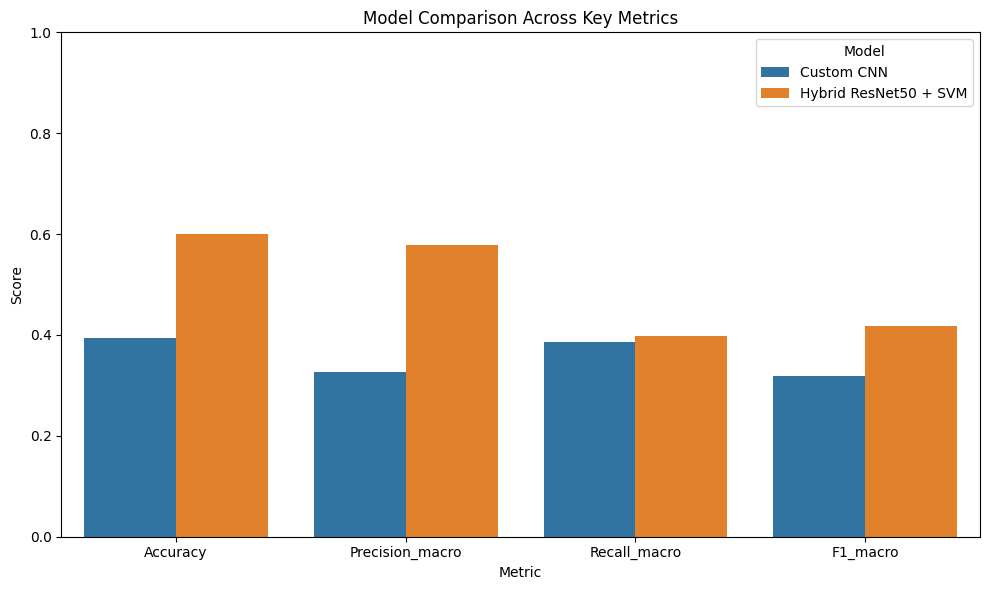

In [ ]:
# Bar chart visualization
metrics_to_plot = ['Accuracy', 'Precision_macro', 'Recall_macro', 'F1_macro']
melted = results_df.melt(id_vars='Model', value_vars=metrics_to_plot,
                         var_name='Metric', value_name='Score')

plt.figure(figsize=(10,6))
sns.barplot(data=melted, x='Metric', y='Score', hue='Model')
plt.title('Model Comparison Across Key Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

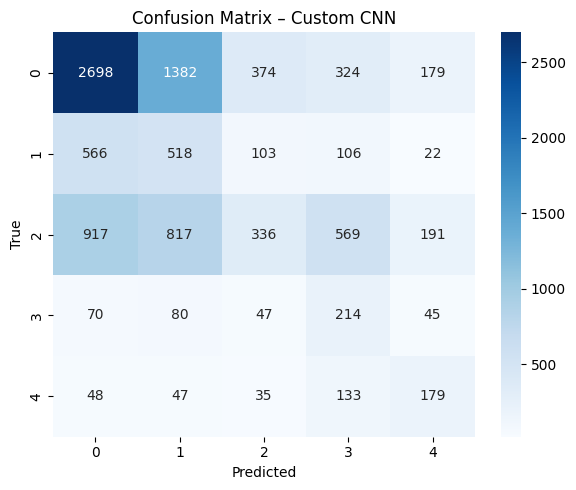

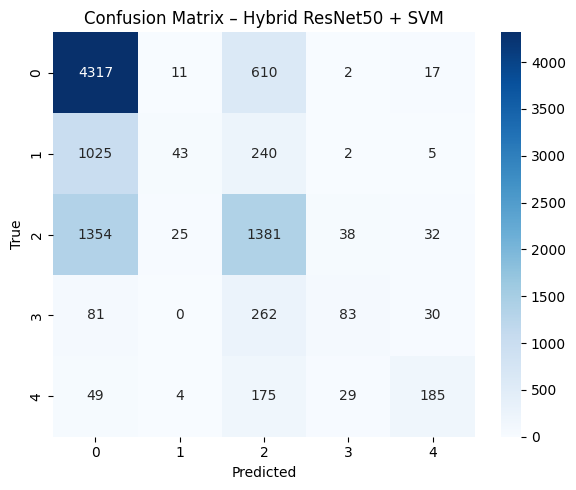

In [ ]:
# Confusion Matrices
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix – {title}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cnn_true, cnn_pred, "Custom CNN")
# plot_confusion_matrix(y_test_svm, svm_pred, "Plain SVM")
plot_confusion_matrix(y_test_hybrid, hybrid_pred, "Hybrid ResNet50 + SVM")

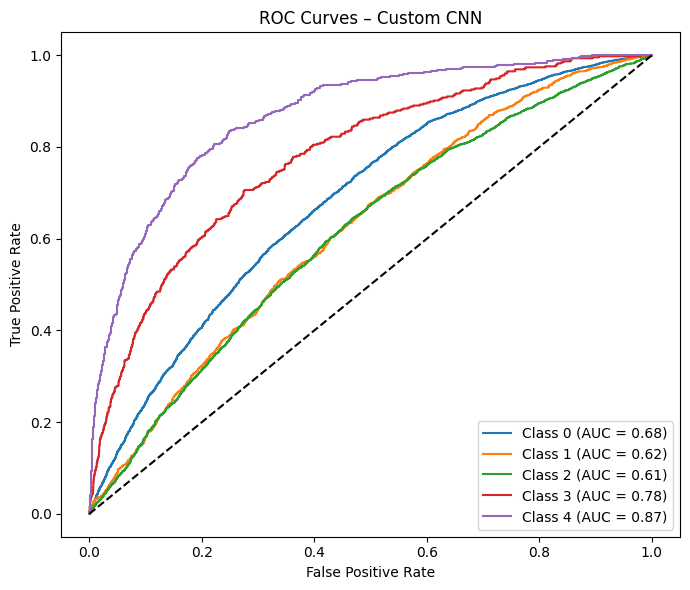

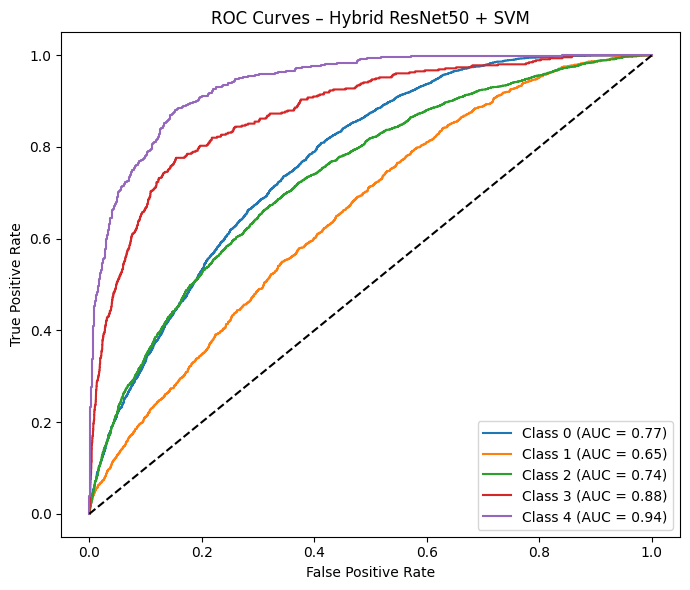

In [ ]:
# CNN probabilities
cnn_prob = cnn_pred_prob

# SVM probabilities
# svm_prob = svm_model.predict_proba(X_test_svm)

# Hybrid probabilities
hybrid_prob = hybrid_svm.predict_proba(X_test_hybrid)

# Binarize labels for ROC
y_true_bin = label_binarize(cnn_true, classes=np.arange(NUM_CLASSES))

def plot_roc(probabilities, model_name):
    plt.figure(figsize=(7,6))
    for i in range(NUM_CLASSES):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], probabilities[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0,1], [0,1], 'k--')
    plt.title(f'ROC Curves – {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_roc(cnn_prob, "Custom CNN")
# plot_roc(svm_prob, "Plain SVM")
plot_roc(hybrid_prob, "Hybrid ResNet50 + SVM")